In [ ]:
# L 4-22-25

# notebooks/1_Explore_Metadata.ipynb

Saved 49598 tracks to ../reports/1_Explore_Metadata/overall_tracks.csv
Saved 8000 valid tracks to ../reports/1_Explore_Metadata/valid_track_genres.csv


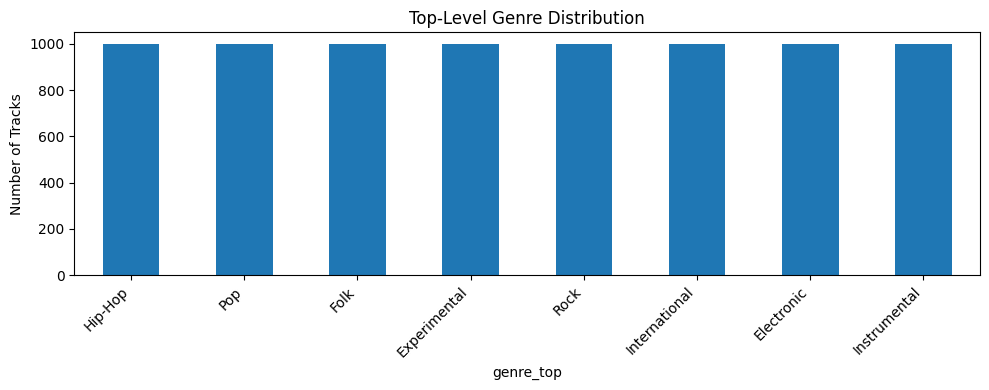

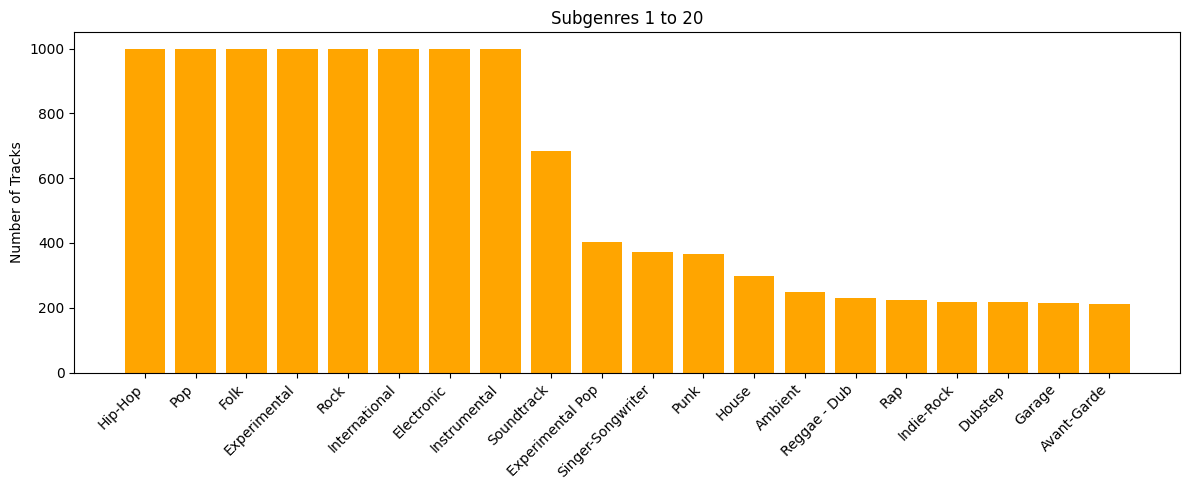

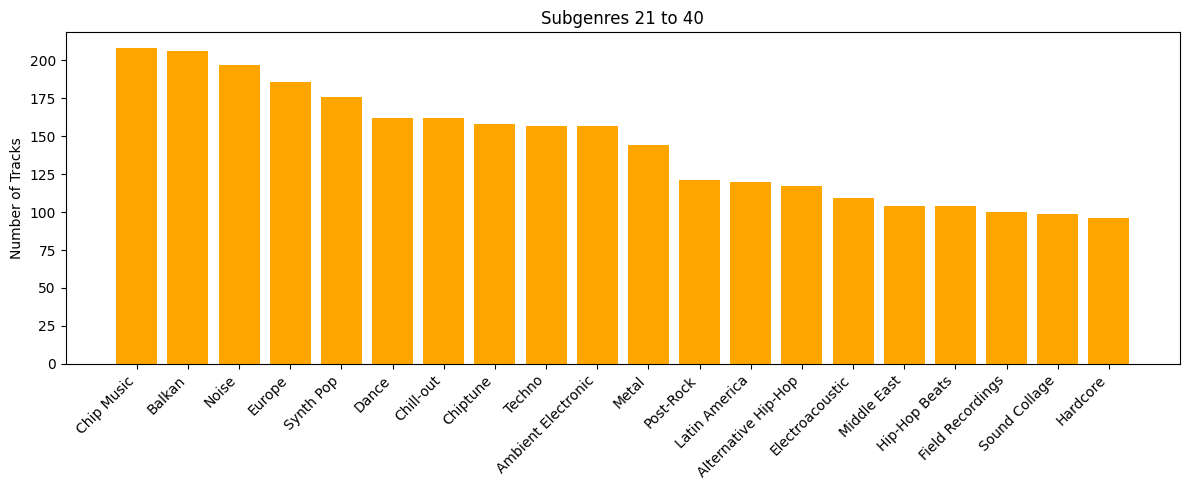

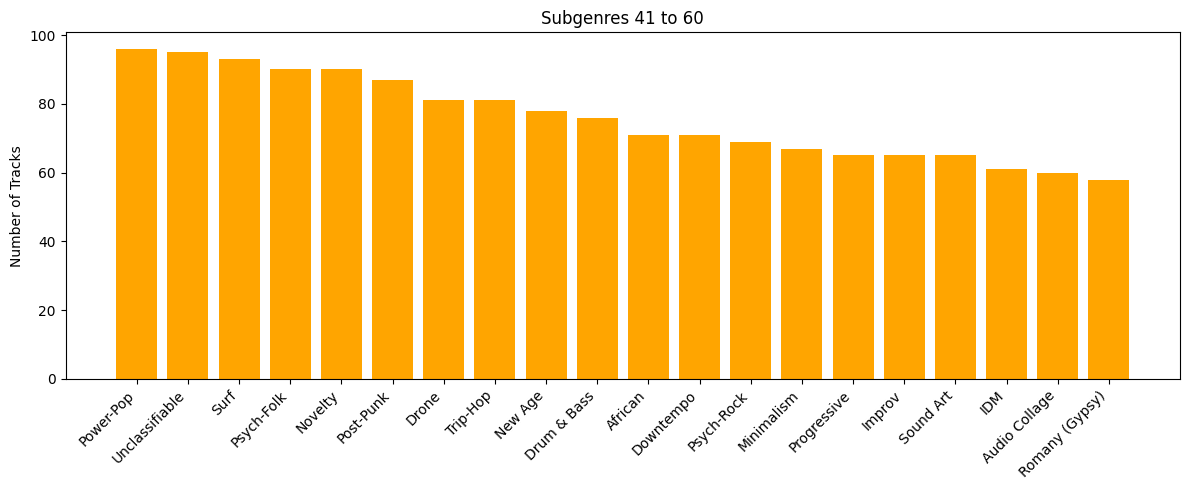

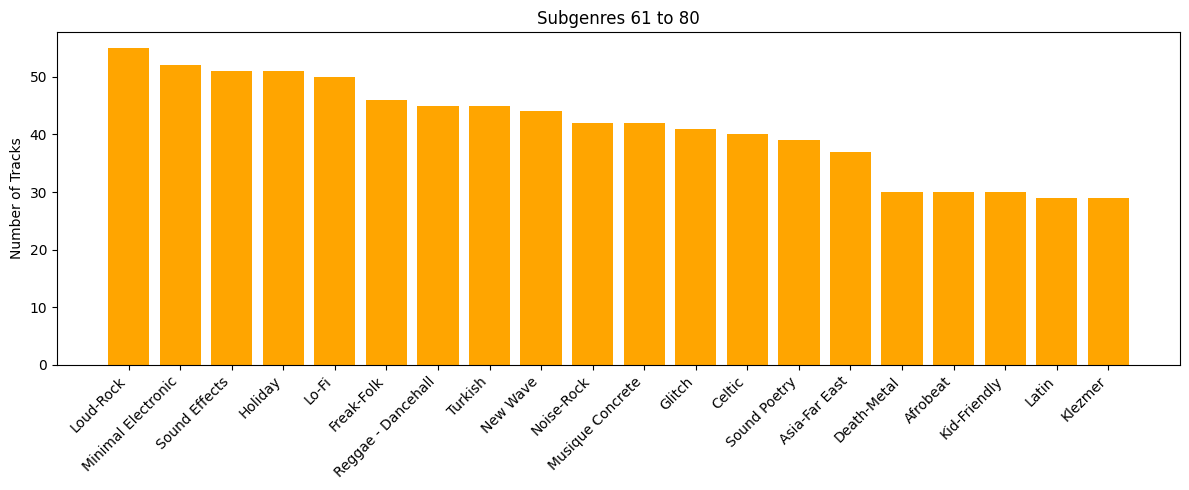

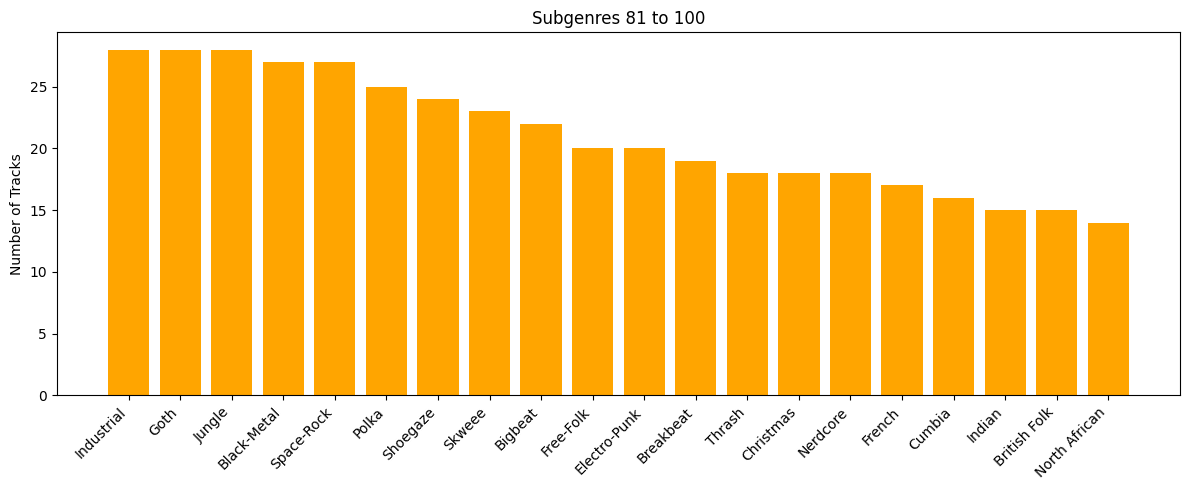

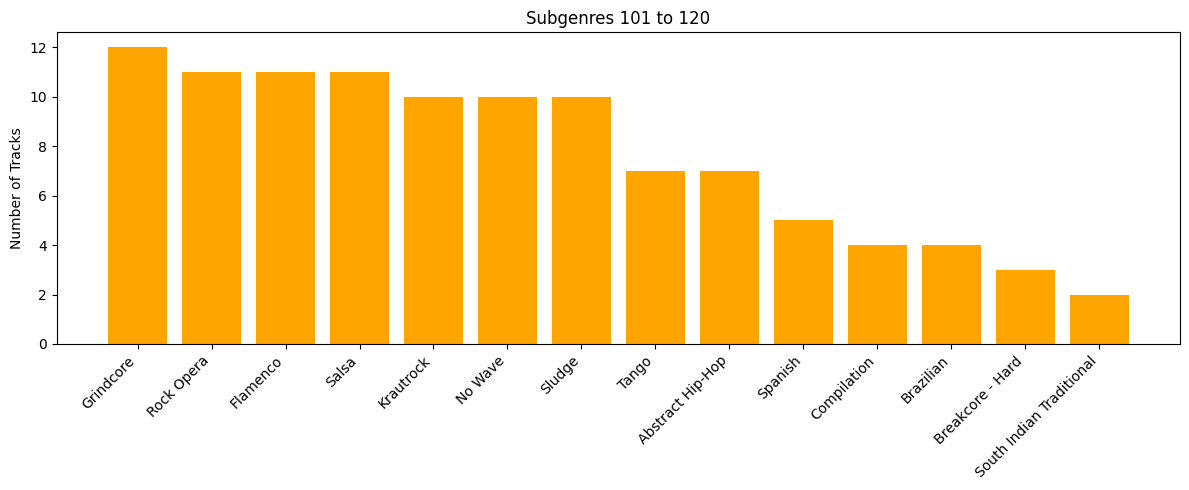

In [2]:
# notebooks/1_Explore_Metadata.ipynb

from math import ceil
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os

# Load metadata files


def load_metadata():
    tracks = pd.read_csv('../data/fma_metadata/tracks.csv',
                         index_col=0, header=[0, 1])
    genres = pd.read_csv('../data/fma_metadata/genres.csv')
    return tracks, genres

# Build genre maps


def build_genre_maps(genres):
    genre_id_to_title = dict(zip(genres['genre_id'], genres['title']))
    genre_id_to_top = dict(zip(genres['genre_id'], genres['top_level']))
    genre_id_to_parent = dict(zip(genres['genre_id'], genres['parent']))
    return genre_id_to_title, genre_id_to_top, genre_id_to_parent

# Parse genre IDs from string


def parse_genre_ids(cell):
    try:
        return ast.literal_eval(cell)
    except Exception:
        return []

# Map genre IDs to titles


def map_genre_ids_to_titles(genre_ids, genre_id_to_title):
    return [genre_id_to_title.get(i, 'Unknown') for i in genre_ids]

# Map genre IDs to top-level titles


def map_genre_ids_to_top_titles(genre_ids, genre_id_to_top, genre_id_to_title):
    return list({genre_id_to_title.get(genre_id_to_top.get(i), 'Unknown') for i in genre_ids})

# Create genre dataframe


def create_genre_dataframe(tracks, genre_id_to_title, genre_id_to_top):
    all_genres = tracks['track', 'genres_all'].apply(parse_genre_ids)
    genre_top = tracks['track', 'genre_top']
    track_ids = tracks.index

    subgenres = [map_genre_ids_to_titles(
        ids, genre_id_to_title) for ids in all_genres]
    top_levels = [map_genre_ids_to_top_titles(
        ids, genre_id_to_top, genre_id_to_title) for ids in all_genres]

    df = pd.DataFrame({
        'track_id': track_ids,
        'genre_top': genre_top,
        'subgenres': subgenres,
        'top_level_genres': top_levels
    })

    return df[df['genre_top'].notna()].reset_index(drop=True)

# Save genre CSVs


def save_dataframes(df):
    overall_path = "../reports/1_Explore_Metadata/overall_tracks.csv"
    valid_path = "../reports/1_Explore_Metadata/valid_track_genres.csv"

    # Save all valid genre-top tracks to reports
    os.makedirs(os.path.dirname(overall_path), exist_ok=True)
    df.to_csv(overall_path, index=False)
    print(f"Saved {len(df)} tracks to {overall_path}")

    # Filter for existing files in fma_small
    def file_exists(track_id):
        tid = str(track_id).zfill(6)
        return os.path.exists(os.path.join("../data/fma_small", tid[:3], f"{tid}.mp3"))

    filtered_df = df[df['track_id'].apply(file_exists)].reset_index(drop=True)

    os.makedirs(os.path.dirname(valid_path), exist_ok=True)
    filtered_df.to_csv(valid_path, index=False)
    print(f"Saved {len(filtered_df)} valid tracks to {valid_path}")

    return df, filtered_df

# Plot top-level genre distribution


def plot_top_level_genres(df, report_dir):
    plt.figure(figsize=(10, 4))
    df['genre_top'].value_counts().plot(kind='bar')
    plt.title("Top-Level Genre Distribution")
    plt.ylabel("Number of Tracks")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(report_dir, "top_level_genres.png"))
    plt.show()

# Plot subgenres in chunks


def plot_subgenre_chunks(df, report_dir, chunk_size=20):
    all_subgenres = [g for genre_list in df['subgenres'] for g in genre_list]
    subgenre_counts = Counter(all_subgenres)
    sorted_subgenres = sorted(subgenre_counts.items(),
                              key=lambda x: x[1], reverse=True)
    num_chunks = ceil(len(sorted_subgenres) / chunk_size)

    for i in range(num_chunks):
        chunk = sorted_subgenres[i * chunk_size:(i + 1) * chunk_size]
        labels, values = zip(*chunk)

        plt.figure(figsize=(12, 5))
        plt.bar(labels, values, color='orange')
        plt.title(f"Subgenres {i * chunk_size + 1} to {(i + 1) * chunk_size}")
        plt.ylabel("Number of Tracks")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        plt.savefig(os.path.join(
            report_dir, f"subgenres_{i * chunk_size + 1}_to_{(i + 1) * chunk_size}.png"))
        plt.show()

# Run all


def main():
    tracks, genres = load_metadata()
    genre_id_to_title, genre_id_to_top, genre_id_to_parent = build_genre_maps(
        genres)
    df_genres = create_genre_dataframe(
        tracks, genre_id_to_title, genre_id_to_top)

    overall_df, valid_df = save_dataframes(df_genres)

    report_dir = "../reports/1_Explore_Metadata"
    plot_top_level_genres(valid_df, report_dir)
    plot_subgenre_chunks(valid_df, report_dir)


if __name__ == "__main__":
    main()